In [28]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import toml
import glob

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
rootdir = "/Users/akshay/research/burrito"
outdirs = [ "tcp-0a7efa1"]

In [30]:
def read_toml(cfg):
    return toml.load(cfg)['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                    
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'tcp-0a7efa1': {'num_clients': [10],
  'file_size': [5000000000],
  'packet_size': [2048, 8192, 4096, 1024],
  'datapath': ['kernel'],
  'iters': 5,
  'bertha': ['full:1',
   'full:3',
   'full:5',
   'full:0',
   'full:4',
   'full:2',
   'raw'],
  'tcp': [True]}}

In [31]:
# note: this aggregates requestclients together

def read_exp(outdir, dp, st, nc, fs, ps, tcp, num_iters):
    exp = []
    for i in range(num_iters):
        fn_wildcard = f"{rootdir}/{outdir}/{dp}_{st}{'_tcp' if tcp else ''}-num_clients={nc}-file_size={fs}-packet_size={ps}-{i}-tbench_client-*.data"
        fn = glob.glob(fn_wildcard)
        if len(fn) != 1:
            raise Exception(f"unexpected number of data files: {fn}")
            
        try:
            df_iter = pd.read_csv(fn[0])
            df_iter["iter"] = i
            df_iter["Commit"] = outdir
            df_iter["Datapath"] = dp
            df_iter["StackType"] = st
            del df_iter["download_size"]
            del df_iter["elapsed_us"]
            del df_iter['tot_bytes']
            exp.append(df_iter)
        except Exception as e:
            pass
    if len(exp) > 0:
        return pd.concat(exp)
    else:
        return pd.DataFrame()

exps = []
for outdir in outdirs:
    cfg = tomls[outdir]
    datapaths = cfg['datapath']
    stack_types = cfg['bertha']
    num_clients = cfg['num_clients']
    file_sizes = cfg['file_size']
    packet_sizes = cfg['packet_size']
    num_iters = cfg['iters']
    tcp = cfg['tcp']
    
    for dp in datapaths:
        for st in stack_types:
            for nc in num_clients:
                for fs in file_sizes:
                    for ps in packet_sizes:
                        for t in tcp:
                            df = read_exp(outdir, dp, st, nc, fs, ps, tcp, num_iters)
                            exps.append(df)
                    
exps = pd.concat(exps)

exps = exps.groupby(["Commit", "Datapath", "StackType", "num_clients", "packet_size"]).quantile([0.25, 0.5, 0.75])
exps = exps.unstack()
exps.columns = [f"{s}_{t}" for s,t in exps.columns.values]
exps.columns = exps.columns.to_flat_index()
exps = exps.reset_index()
exps

,Commit,Datapath,StackType,num_clients,packet_size,tot_pkts_0.25,tot_pkts_0.5,tot_pkts_0.75,rate_bps_0.25,rate_bps_0.5,rate_bps_0.75,rate_pps_0.25,rate_pps_0.5,rate_pps_0.75,iter_0.25,iter_0.5,iter_0.75
0,tcp-0a7efa1,kernel,full:0,10,1024,48828140.0,48828140.0,48828140.0,8.991309e+09,1.454287e+10,1.463219e+10,1.097572e+06,1.775253e+06,1.786157e+06,1.0,2.0,3.0
1,tcp-0a7efa1,kernel,full:0,10,2048,24414080.0,24414080.0,24414080.0,1.634380e+10,1.776630e+10,2.087001e+10,9.975471e+05,1.084370e+06,1.273805e+06,1.0,2.0,3.0
2,tcp-0a7efa1,kernel,full:0,10,4096,12207050.0,12207050.0,12207050.0,2.034836e+10,2.038196e+10,2.324830e+10,6.209837e+05,6.220090e+05,7.094829e+05,1.0,2.0,3.0
3,tcp-0a7efa1,kernel,full:0,10,8192,6103530.0,6103530.0,6103530.0,2.349232e+10,2.350948e+10,2.351234e+10,3.584651e+05,3.587270e+05,3.587706e+05,1.0,2.0,3.0
4,tcp-0a7efa1,kernel,full:1,10,1024,48828140.0,48828140.0,48828140.0,1.355150e+10,1.370348e+10,1.406700e+10,1.654236e+06,1.672789e+06,1.717164e+06,1.0,2.0,3.0
5,tcp-0a7efa1,kernel,full:1,10,2048,24414080.0,24414080.0,24414080.0,1.645046e+10,1.704334e+10,2.147155e+10,1.004057e+06,1.040244e+06,1.310520e+06,1.0,2.0,3.0
6,tcp-0a7efa1,kernel,full:1,10,4096,12207050.0,12207050.0,12207050.0,2.333742e+10,2.335999e+10,2.336378e+10,7.122027e+05,7.128914e+05,7.130072e+05,1.0,2.0,3.0
7,tcp-0a7efa1,kernel,full:1,10,8192,6103530.0,6103530.0,6103530.0,2.348387e+10,2.350953e+10,2.351132e+10,3.583362e+05,3.587278e+05,3.587551e+05,1.0,2.0,3.0
8,tcp-0a7efa1,kernel,full:2,10,1024,48828140.0,48828140.0,48828140.0,9.133951e+09,9.300506e+09,9.731735e+09,1.114985e+06,1.135316e+06,1.187956e+06,1.0,2.0,3.0
9,tcp-0a7efa1,kernel,full:2,10,2048,24414080.0,24414080.0,24414080.0,1.931549e+10,2.107101e+10,2.128572e+10,1.178925e+06,1.286073e+06,1.299178e+06,1.0,2.0,3.0


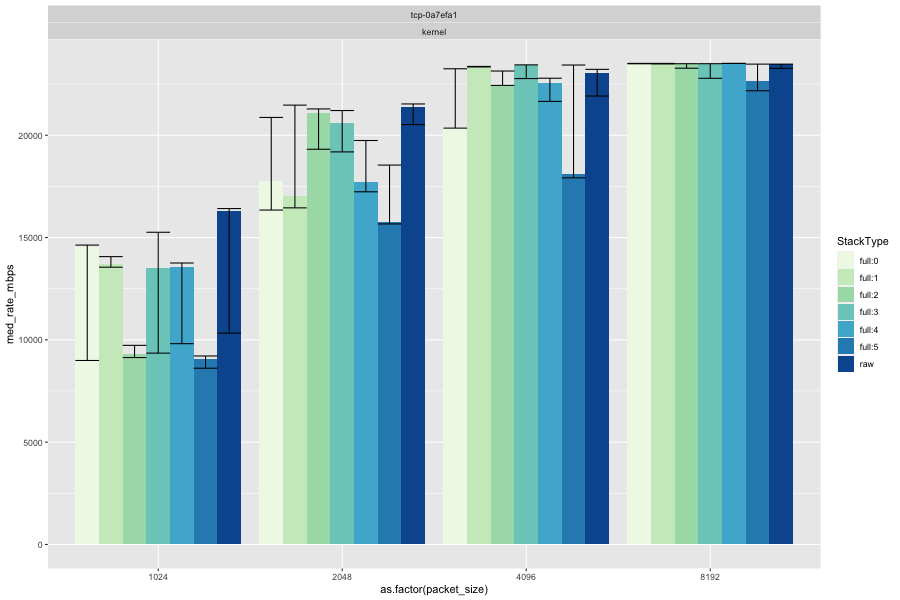

In [32]:
%%R -i exps -w 900 -h 600

# Mbit/s graph (throughput)

library(ggplot2)

exps$med_rate_mbps <- exps$rate_bps_0.5 / 1e6
exps$low_rate_mbps <- exps$rate_bps_0.25 / 1e6
exps$hih_rate_mbps <- exps$rate_bps_0.75 / 1e6
ggplot(exps, aes(x=as.factor(packet_size), y=med_rate_mbps, fill=StackType)) +
  geom_col(position="dodge") +
  geom_errorbar(aes(ymin=low_rate_mbps, ymax=hih_rate_mbps), position="dodge") +
  scale_fill_brewer(type="seq", palette=4) +
  facet_wrap(Commit ~ Datapath) 

In [33]:
exps.to_csv("tcp-0a7efa1.csv")